<a href="https://colab.research.google.com/github/pragy19/Used_car_price_prediction-/blob/main/car_price_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
# === Import libraries ===
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Ignore warnings
warnings.filterwarnings("ignore")
import pickle



In [104]:
# 1. Load the Data

try:
    car = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_resume/used_cars.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Dataset not found. Please ensure 'used_cars.csv' is in the correct directory.")
    exit()

Dataset loaded successfully.


In [105]:
print(car.head())

      brand                            model  model_year      milage  \
0      Ford  Utility Police Interceptor Base        2013  51,000 mi.   
1   Hyundai                     Palisade SEL        2021  34,742 mi.   
2     Lexus                    RX 350 RX 350        2022  22,372 mi.   
3  INFINITI                 Q50 Hybrid Sport        2015  88,900 mi.   
4      Audi        Q3 45 S line Premium Plus        2021   9,835 mi.   

       fuel_type                                             engine  \
0  E85 Flex Fuel  300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...   
1       Gasoline                               3.8L V6 24V GDI DOHC   
2       Gasoline                                     3.5 Liter DOHC   
3         Hybrid  354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...   
4       Gasoline                         2.0L I4 16V GDI DOHC Turbo   

        transmission                 ext_col int_col  \
0        6-Speed A/T                   Black   Black   
1  8-Speed Automatic        

In [106]:
# Initial Data Cleaning and Feature Engineering
# First, let's clean the 'price' and 'milage' columns to make them numeric.
car['price'] = car['price'].str.replace('$', '').str.replace(',', '', regex=False).astype(int)
car['milage'] = car['milage'].str.replace(' mi.', '', regex=False).str.replace(',', '', regex=False).astype(int)

# Extract numerical features from 'engine' and handle missing values
car['horsepower'] = car['engine'].str.extract(r'(\d+\.?\d*)\s*HP').astype(float)
car['liters'] = car['engine'].str.extract(r'(\d+\.?\d*)\s*L').astype(float)

# Impute missing horsepower and liters with the overall median
car['horsepower'] = car['horsepower'].fillna(car['horsepower'].median())
car['liters'] = car['liters'].fillna(car['liters'].median())

# Create 'car_age' feature
car['car_age'] = 2025 - car['model_year']

# Log transform the target and a key feature
car['log_milage'] = np.log1p(car['milage'])
car['log_price'] = np.log1p(car['price'])

# Group rare categorical features to reduce dimensionality
for col in ['ext_col', 'int_col', 'brand', 'fuel_type', 'transmission', 'model']:
    value_counts = car[col].value_counts()
    car[col] = car[col].apply(lambda x: x if value_counts.get(x, 0) >= 50 else 'Other')

In [107]:
print(car.head())

      brand  model  model_year  milage      fuel_type  \
0      Ford  Other        2013   51000  E85 Flex Fuel   
1   Hyundai  Other        2021   34742       Gasoline   
2     Lexus  Other        2022   22372       Gasoline   
3  INFINITI  Other        2015   88900         Hybrid   
4      Audi  Other        2021    9835       Gasoline   

                                              engine       transmission  \
0  300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...        6-Speed A/T   
1                               3.8L V6 24V GDI DOHC  8-Speed Automatic   
2                                     3.5 Liter DOHC          Automatic   
3  354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...        7-Speed A/T   
4                         2.0L I4 16V GDI DOHC Turbo  8-Speed Automatic   

  ext_col int_col                                accident clean_title  price  \
0   Black   Black  At least 1 accident or damage reported         Yes  10300   
1   Other    Gray  At least 1 accident or dama

In [108]:
# 2. Exploring & visualizing the data to gain insights
sns.set_style("whitegrid")

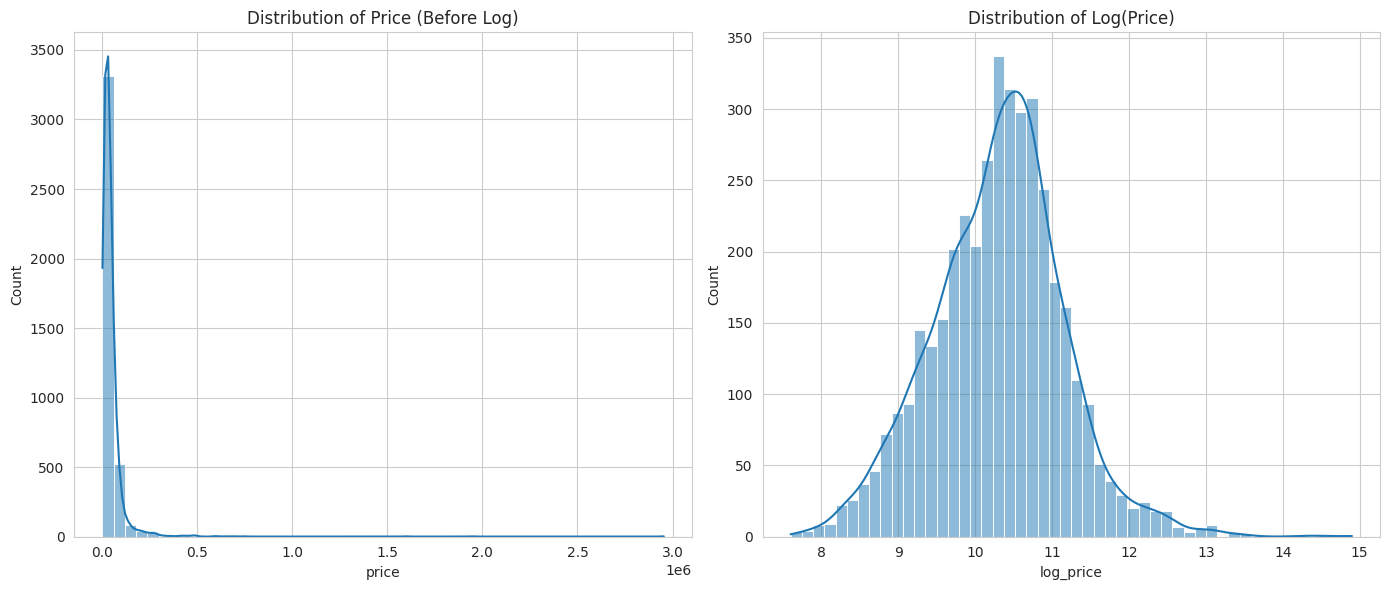

In [109]:
# Histograms for key numerical features
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(car['price'], bins=50, kde=True)
plt.title('Distribution of Price (Before Log)')
plt.subplot(1, 2, 2)
sns.histplot(car['log_price'], bins=50, kde=True)
plt.title('Distribution of Log(Price)')
plt.tight_layout()
plt.show()


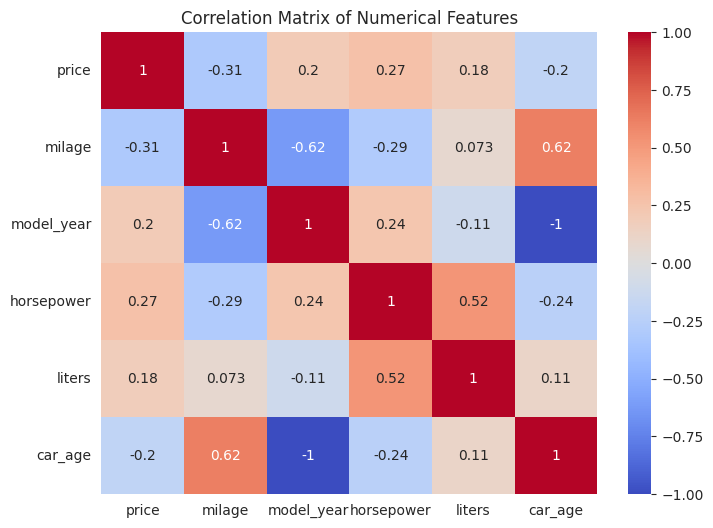

In [110]:

# Heatmap for correlations
plt.figure(figsize=(8, 6))
sns.heatmap(car[['price', 'milage', 'model_year', 'horsepower', 'liters', 'car_age']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


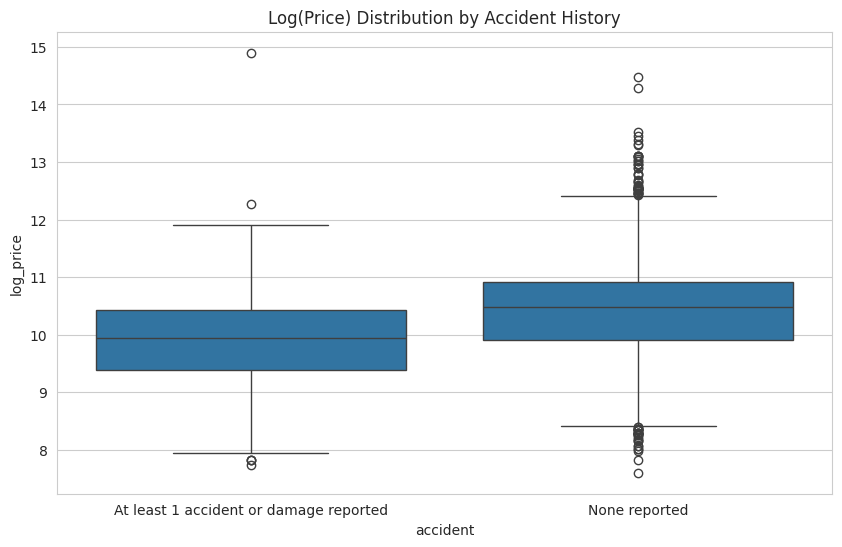

In [111]:
# Box plot for price by accident history
plt.figure(figsize=(10, 6))
sns.boxplot(x='accident', y='log_price', data=car)
plt.title('Log(Price) Distribution by Accident History')
plt.show()


In [112]:
# 3. Preparing the data for ML algorithms
# Define features (X) and target (y)
if not car.empty:
    X = car.drop(['price', 'log_price'], axis=1)
    y = car['log_price']

    # CRITICAL ADDITION: Cap the outliers in the target variable and mileage
    y = y.clip(y.quantile(0.05), y.quantile(0.95))
    X['log_milage'] = X['log_milage'].clip(X['log_milage'].quantile(0.05), X['log_milage'].quantile(0.95))

    # Define the columns for each type of preprocessing
    numerical_features = ['log_milage', 'car_age', 'horsepower', 'liters']
    categorical_features = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

    # Build a preprocessing pipeline using ColumnTransformer
    # This simplifies the data prep by applying different transformations to different columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ],
        remainder='drop'  # Drop any columns not specified
    )

    # Apply the preprocessing
    X_processed = preprocessor.fit_transform(X)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")

    # Custom function to calculate RMSE on the original price scale
    def root_mean_squared_error_original(y_true_log, y_pred_log):
        # Convert log-transformed values back to original scale
        y_true = np.expm1(y_true_log)
        y_pred = np.expm1(y_pred_log)
        return np.sqrt(mean_squared_error(y_true, y_pred))

Training set shape: (3207, 76)
Test set shape: (802, 76)


In [113]:
# Custom function to calculate RMSE on the original price scale
def root_mean_squared_error_original(y_true_log, y_pred_log):
    # Convert log-transformed values back to original scale
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))


--- Training Linear Regression ---
Linear Regression RMSE on test set: 15064.48


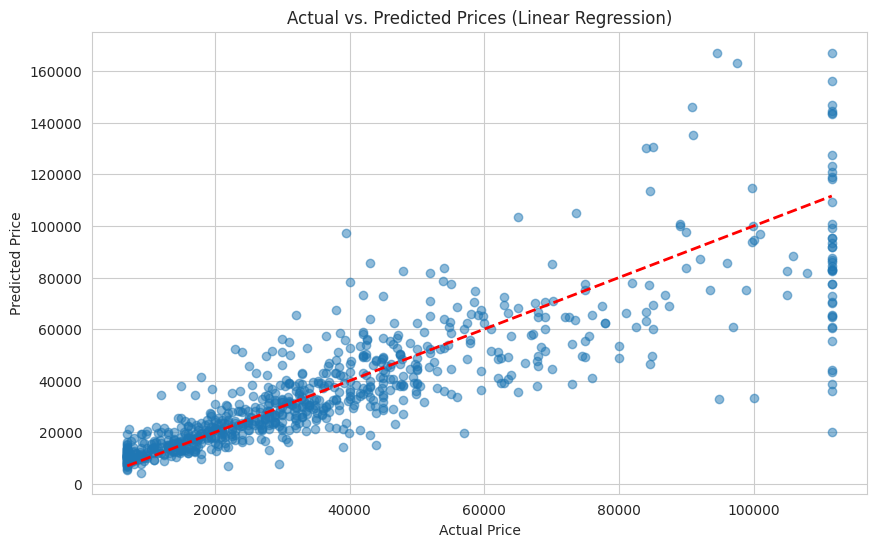


--- Training Random Forest ---
Random Forest RMSE on test set: 11167.60


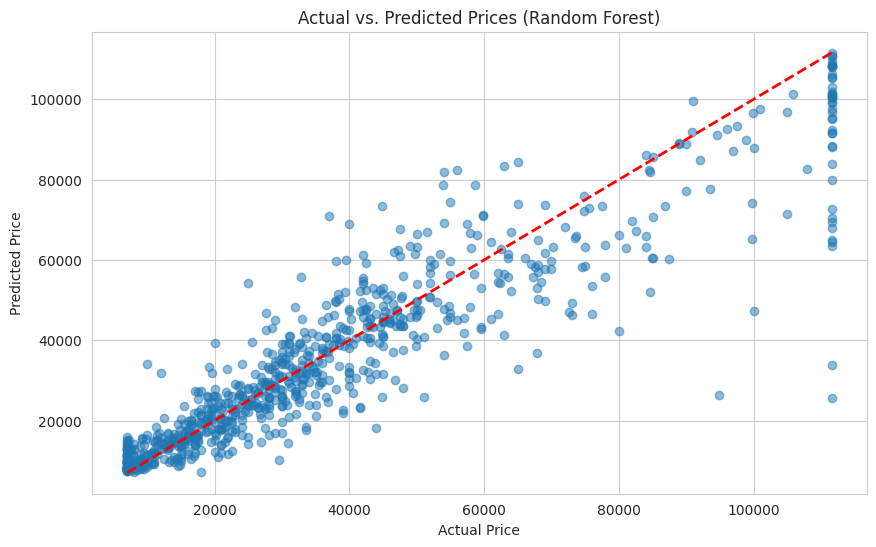


--- Training XGBoost ---
XGBoost RMSE on test set: 10476.75


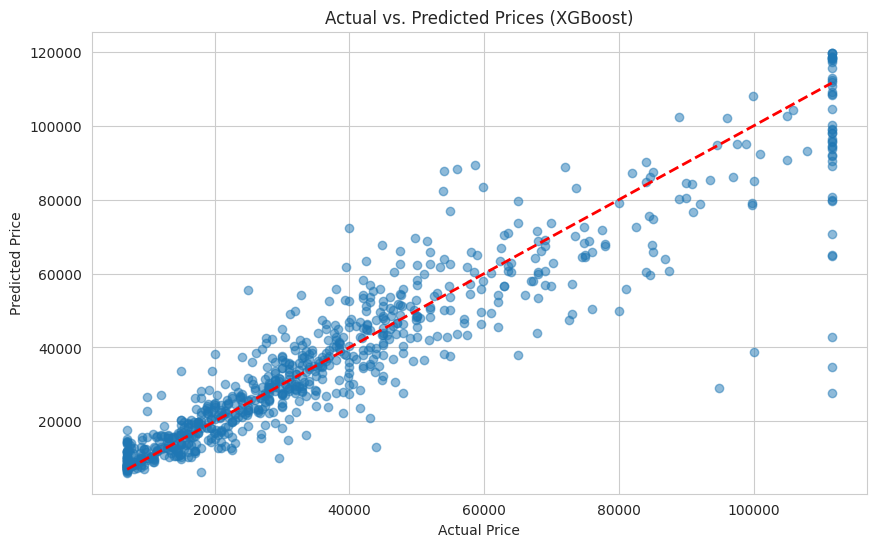

In [114]:
# 4. Select and Train Models
# We will train the three models directly without hyperparameter tuning to simplify the code.

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error_original(y_test, y_pred)
    results[name] = rmse
    print(f"{name} RMSE on test set: {rmse:.2f}")

    # Plot actual vs. predicted prices
    plt.figure(figsize=(10, 6))
    plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
    plt.plot(
        [np.expm1(y_test).min(), np.expm1(y_test).max()],
        [np.expm1(y_test).min(), np.expm1(y_test).max()],
        'r--', lw=2
    )
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'Actual vs. Predicted Prices ({name})')
    plt.show()



=== Model Performance Summary ===
| Model             |   Test RMSE |
|:------------------|------------:|
| XGBoost           |     10476.7 |
| Random Forest     |     11167.6 |
| Linear Regression |     15064.5 |

--- Feature Importance (XGBoost) ---
| feature                  |   importance |
|:-------------------------|-------------:|
| num__log_milage          |    0.0947387 |
| cat__brand_Porsche       |    0.0907532 |
| num__horsepower          |    0.0667807 |
| num__car_age             |    0.0621577 |
| cat__fuel_type_Diesel    |    0.0618593 |
| cat__brand_Nissan        |    0.0335854 |
| num__liters              |    0.0306144 |
| cat__brand_RAM           |    0.0267093 |
| cat__brand_Lexus         |    0.0255227 |
| cat__brand_Mercedes-Benz |    0.0228387 |


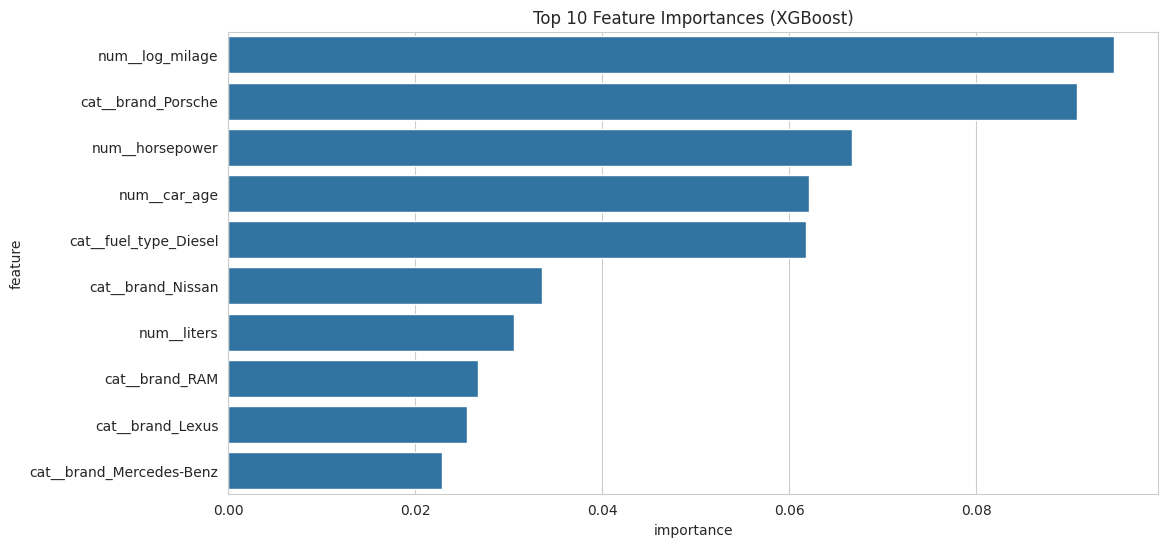

In [115]:
# 5. Conclusion
# Compare the results
print("\n=== Model Performance Summary ===")
summary_df = pd.DataFrame(list(results.items()), columns=['Model', 'Test RMSE'])
summary_df = summary_df.sort_values(by='Test RMSE')
print(summary_df.to_markdown(index=False))

# Feature Importance for XGBoost
print("\n--- Feature Importance (XGBoost) ---")
# Get feature names from the preprocessor's one-hot encoder
feature_names = preprocessor.get_feature_names_out()
# Get feature importances from the trained XGBoost model
importances = models['XGBoost'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print(feature_importance_df.head(10).to_markdown(index=False))

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()

In [116]:
# 6. Saving Model and Preprocessor for Future Use

print("\n--- Saving the Best Model and Preprocessor ---")

# The best model is typically the one with the lowest RMSE.
# From your previous runs, XGBoost performed best.
# Find the best model automatically from results
best_model_name = min(results, key=results.get)  # model with lowest RMSE
best_model_to_save = models[best_model_name]     # get the trained model object

# Save the trained model
with open('car_price_predictor_model.pkl', 'wb') as file:
    pickle.dump(best_model_to_save, file)

# Save the preprocessor
with open('car_price_preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

print("Model and preprocessor saved successfully as .pkl files.")



--- Saving the Best Model and Preprocessor ---
Model and preprocessor saved successfully as .pkl files.


In [117]:
# =========================================================================
# 7. Example of How to Load and Use the Saved Model
# =========================================================================
print("\n--- Example: Loading and Making a New Prediction ---")

try:
    # Load the saved model and preprocessor
    with open('car_price_predictor_model.pkl', 'rb') as file:
        loaded_model = pickle.load(file)

    with open('car_price_preprocessor.pkl', 'rb') as file:
        loaded_preprocessor = pickle.load(file)

    print("Model and preprocessor loaded.")

    # Create a new data point (this is what a user would input in your app)
    new_car_data = pd.DataFrame([{
        'brand': 'Ford',
        'model': 'F-150',
        'model_year': 2020,
        'milage': 30000,
        'fuel_type': 'Gasoline',
        'engine': '5.0L V8',
        'transmission': 'A/T',
        'ext_col': 'Black',
        'int_col': 'Black',
        'accident': 'None reported',
        'clean_title': 'Yes'
    }])

    # Perform the same feature engineering steps as before
    new_car_data['horsepower'] = new_car_data['engine'].str.extract(r'(\d+\.?\d*)\s*HP').astype(float)
    new_car_data['liters'] = new_car_data['engine'].str.extract(r'(\d+\.?\d*)\s*L').astype(float)
    new_car_data['horsepower'] = new_car_data['horsepower'].fillna(car['horsepower'].median())
    new_car_data['liters'] = new_car_data['liters'].fillna(car['liters'].median())
    new_car_data['car_age'] = 2025 - new_car_data['model_year']
    new_car_data['log_milage'] = np.log1p(new_car_data['milage'])

    # Apply the loaded preprocessor to the new data
    # (Important: use .transform(), not .fit_transform())
    new_car_processed = loaded_preprocessor.transform(new_car_data)

    # Make a prediction
    predicted_log_price = loaded_model.predict(new_car_processed)

    # Convert the prediction back to the original price scale
    predicted_price = np.expm1(predicted_log_price)

    print(f"Predicted price for the new car: ${predicted_price[0]:,.2f}")

except FileNotFoundError:
    print("Model files not found. Please run the script to create them first.")



--- Example: Loading and Making a New Prediction ---
Model and preprocessor loaded.
Predicted price for the new car: $57,823.79
